# Prescriptor Experiments
#### This notebook is to replicate the process used in [Discovering Effective Policies for Land-Use Planning](https://doi.org/10.48550/arXiv.2311.12304)

In [1]:
import os
from pathlib import Path

import torch
from tqdm import tqdm
import pandas as pd
from pymoo.indicators.hv import Hypervolume
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from prsdk.predictors.neural_network.neural_net_predictor import NeuralNetPredictor

from data import constants
from data.eluc_data import ELUCData
from prsdk.persistence.serializers.neural_network_serializer import NeuralNetSerializer
from prescriptors.nsga2.candidate import Candidate
from prescriptors.nsga2.land_use_prescriptor import LandUsePrescriptor
from prescriptors.prescriptor_manager import PrescriptorManager
from prescriptors.heuristics.heuristics import EvenHeuristic, PerfectHeuristic, NoCropHeuristic
from prsdk.predictors.neural_network.neural_net_predictor import NeuralNetPredictor
from predictors.percent_change.percent_change_predictor import PercentChangePredictor
from predictors.percent_change.crop_change_predictor import CropChangePredictor

In [2]:
dataset = ELUCData.from_hf()
encoder = dataset.encoder

### Load Results

In [3]:
TOTAL_GENS = 100
OUTCOMES = ["ELUC", "change", "cropchange"]
results_dir = Path("prescriptors/nsga2/training_runs/eds")

In [4]:
def create_pareto_df(gen: int, results_dir: Path):
    last_gen_filename = results_dir / f"{gen}.csv"
    last_gen_df = pd.read_csv(last_gen_filename)
    pareto_df = last_gen_df[last_gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    pareto_df = pareto_df.sort_values(by='change', ascending=True)
    return pareto_df

In [5]:
pareto_df = create_pareto_df(TOTAL_GENS, results_dir)

### Figure Save Dir

In [6]:
figure_dir = Path("experiments/figures/eds")
figure_dir.mkdir(parents=True, exist_ok=True)

## Generation Plotting

In [7]:
def get_pareto_df(dir, gen):
    """
    Gets the pareto df for a given generation.
    :param dir: The experiment results directory.
    :param gen: The generation to get the pareto df for.
    """
    gen_filename = os.path.join(dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

def get_merged_df(dir, gens):
    """
    Gets the pareto df for multiple generations and merges them into one.
    :param dir: The experiment results directory.
    :param gens: List of generations to get the pareto df for.
    """
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(dir, gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def get_overall_pareto_df(final_gen: int, results_dir: Path):
    pareto_list = []
    pareto_dfs = []
    for gen in range(1, final_gen + 1):
        gen_path = results_dir / f"{gen}.csv"      
        gen_df = pd.read_csv(gen_path)
        gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
        pareto_dfs.append(gen_pareto_df)

    all_pareto_df = pd.concat(pareto_dfs, ignore_index=True)
    all_pareto_df = all_pareto_df.drop_duplicates(subset=["id"])

    for _, add in all_pareto_df.iterrows():
        pareto = True
        for _, compare in all_pareto_df.iterrows():
            dominated = False
            for outcome in OUTCOMES:
                if add[outcome] < compare[outcome]:
                    dominated = False
                    break
                if add[outcome] > compare[outcome]:
                    dominated = True
            if dominated:
                pareto = False
                break
        if pareto:
            pareto_list.append(add)

    return pd.DataFrame(pareto_list)


def plot_gens(dir, gens, outcomes, save_path=None):
    """
    Plots the pareto front for multiple generations.
    :param dir: The experiment results directory.
    :param gens: List of generations to plot the pareto front for.
    """
    merged_df = get_merged_df(dir, gens)
    merged_df = merged_df.sort_values(by=outcomes[0])
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in [0, 1, 2, 5, 4]]
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)

        curve = merged_df[merged_df["Name"] == curve_name]
        plt.scatter(curve[outcomes[0]], curve[outcomes[1]], color=colors[i], label= "Gen " + str(gen))

    overall_pareto_df = get_overall_pareto_df(gens[-1], dir)

    overall_pareto_df = overall_pareto_df.sort_values(by=outcomes[0])
    plt.scatter(overall_pareto_df[outcomes[0]], overall_pareto_df[outcomes[1]], color="r", label="Final Pareto Front")
    #plt.xlim(0, 0.4)
    plt.grid() 
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 1, 2, 4, 3]
    # plt.legend([handles[idx] for idx in order], [curve_names[idx] for idx in order], loc="upper right")
    plt.xlabel(outcomes[0])
    plt.ylabel(outcomes[1])
    plt.legend(prop={'size': 9})
    #plt.title("Pareto Fronts Across Generations")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

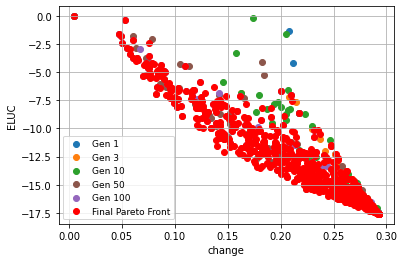

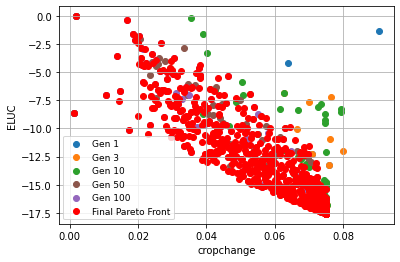

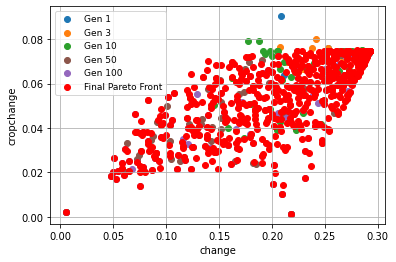

In [8]:
gens_to_plot = [1, 3, 10, 50, 100]
plot_gens(results_dir, gens_to_plot, ["change", "ELUC"], save_path=None)
plot_gens(results_dir, gens_to_plot, ["cropchange", "ELUC"], save_path=None)
plot_gens(results_dir, gens_to_plot, ["change", "cropchange"], save_path=None)

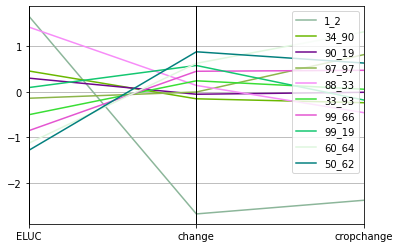

In [9]:
def plot_parallel_coordinates(gen: int, results_dir: Path):
    gen_df = create_pareto_df(gen, results_dir).iloc[:10]
    gen_df[OUTCOMES] = (gen_df[OUTCOMES] - gen_df[OUTCOMES].mean()) / gen_df[OUTCOMES].std()
    pd.plotting.parallel_coordinates(gen_df, "id", cols=OUTCOMES)

plot_parallel_coordinates(TOTAL_GENS, results_dir)

In [10]:
def get_gen_df(gen: int, results_dir: Path):
    gen_filename = results_dir / f"{gen}.csv"
    gen_df = pd.read_csv(gen_filename)
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_df = gen_df.sort_values(by='change', ascending=True)
    gen_df["Name"] = f"Gen {gen}"
    return gen_df

def get_all_gens_df(gens: list, results_dir: Path):
    dfs = []
    for gen in gens:
        dfs.append(get_gen_df(gen, results_dir))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [11]:
def plot_all_gens(gens: list, outcomes: list[str], results_dir: Path, save_path=None):
    all_gens_df = get_all_gens_df(gens, results_dir)
    fig, ax = plt.subplots()

    all_gens_df.plot.scatter(x=outcomes[0],
                             y=outcomes[1],
                             ax=ax,
                             label="All prescriptors evaluated")
    # Plot last gen's pareto front in red
    
    #get_pareto_df(dir, gens[-1]).plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Gen 100 Pareto Front")
    overall_pareto = get_overall_pareto_df(gens[-1], results_dir)
    overall_pareto.plot.scatter(x=outcomes[0], y=outcomes[1], c='red', ax=ax, label="Final Pareto Front")
    plt.grid()
    #plt.title("All Generations All Prescriptor Performance")
    plt.legend(loc="upper left")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300) 
    plt.show()

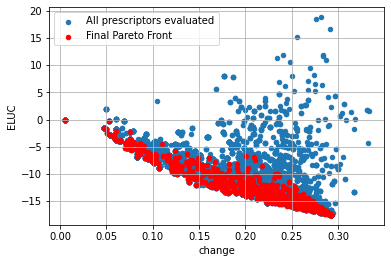

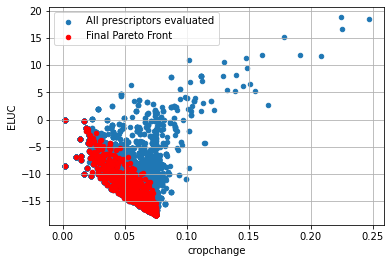

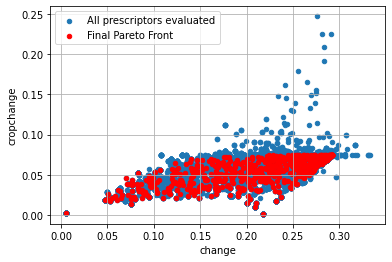

In [12]:
all_gens = [a + 1 for a in range(100)]
plot_all_gens(all_gens, ["change", "ELUC"], results_dir, save_path=None)
plot_all_gens(all_gens, ["cropchange", "ELUC"], results_dir, save_path=None)
plot_all_gens(all_gens, ["change", "cropchange"], results_dir, save_path=None)

In [13]:
all_pareto_df = get_overall_pareto_df(100, results_dir)

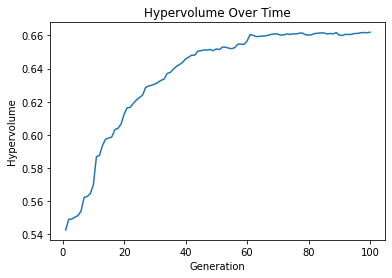

In [14]:
def plot_hypervolume(outcomes: list[str],
                     results_dir: Path,
                     ref_point=np.array([17.375717, 0.29098859373497826, 0.07468234]),
                     ideal=np.array([-17.375717, 0, 0]),):
    """
    Plots the hypervolume of our experiment.
    For the worst possible point we use -1 * the ideal eluc seed, and the 2 max changes from the seeds.
    For the best possible point we use the ideal eluc seed with 0 change.
    """
    nadir = ref_point
    metric = Hypervolume(ref_point=ref_point,
                         norm_ref_point=True,
                         zero_to_one=True,
                         ideal=ideal,
                         nadir=nadir)
    hypervolumes = []
    for gen in range(1, TOTAL_GENS+1):
        results_df = pd.read_csv(results_dir / f"{gen}.csv")
        F = results_df[outcomes].values
        hypervolumes.append(metric.do(F))


    plt.plot(range(1, TOTAL_GENS+1), hypervolumes)
    plt.xlabel("Generation")
    plt.ylabel("Hypervolume")
    plt.title("Hypervolume Over Time")
    plt.show()

plot_hypervolume(OUTCOMES, results_dir)

## Comparison with Heuristic

In [15]:
def load_candidate(results_dir: Path, cand_id: str, cand_params: dict[str, int]) -> Candidate:
    cand_path = results_dir / str(int(cand_id.split('_')[0])+1) / f"{cand_id}.pt"
    cand = Candidate(**cand_params, device="mps", cand_id=cand_id)
    cand.load_state_dict(torch.load(cand_path))
    return cand

In [16]:
nn_serializer = NeuralNetSerializer()
nnp = nn_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-nn"))
change_predictor = PercentChangePredictor()
cropchange_predictor = CropChangePredictor()
predictors = {"ELUC": nnp, "change": change_predictor, "cropchange": cropchange_predictor}

candidate_params = {"in_size": len(constants.CAO_MAPPING["context"]), "hidden_size": 16, "out_size": len(constants.RECO_COLS)}
# Set up new PrescriptorManager
cands = [load_candidate(results_dir, cand_id, candidate_params) for cand_id in all_pareto_df["id"]]
prescs = {cand.cand_id: LandUsePrescriptor(cand, encoder) for cand in cands}
torch_manager = PrescriptorManager(prescs, predictors)

In [17]:
test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = encoder.encode_as_df(test_df)

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

### Trained Prescriptors

In [18]:
def evaluate_prescriptor(prescriptor_manager: PrescriptorManager, cand_id: str, context_df: pd.DataFrame):
    context_actions_df = prescriptor_manager.prescribe(cand_id, context_df)
    outcome_df = prescriptor_manager.predict_metrics(context_actions_df)
    return outcome_df["ELUC"].mean(), outcome_df["change"].mean(), outcome_df["cropchange"].mean()

In [19]:
assert len(all_pareto_df["id"].unique()) == len(all_pareto_df)

ids = all_pareto_df["id"].tolist()
elucs = []
changes = []
cropchanges = []
for cand_id in tqdm(ids):
    eluc, change, cropchange = evaluate_prescriptor(torch_manager, cand_id, context_df)
    elucs.append(eluc)
    changes.append(change)
    cropchanges.append(cropchange)

100%|██████████| 544/544 [02:53<00:00,  3.14it/s]


### Heuristics

In [21]:
pcts = [i/len(ids) for i in range(1, len(ids) + 1)]

linreg = LinearRegression()
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
coefs = linreg.coef_
coef_dict = dict(zip(constants.LAND_USE_COLS, coefs))
reco_coefs = []
for col in constants.RECO_COLS:
    reco_coefs.append(coef_dict[col])
even_manager = PrescriptorManager({str(pct): EvenHeuristic(pct, "secdf") for pct in pcts}, predictors)
perfect_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, predictors)
crop_manager = PrescriptorManager({str(pct): NoCropHeuristic(pct, reco_coefs) for pct in pcts}, predictors)

In [23]:
print(dict(zip(constants.RECO_COLS, reco_coefs)))

{'crop': 110.33926, 'pastr': 58.705685, 'range': 27.738625, 'secdf': -16.832415, 'secdn': 26.697311}


In [24]:
even_elucs, even_changes, even_cropchanges = [], [], []
perfect_elucs, perfect_changes, perfect_cropchanges = [], [], []
crop_elucs, crop_changes, crop_cropchanges = [], [], []
for pct in tqdm(pcts):
    even_eluc, even_change, even_cropchange = evaluate_prescriptor(even_manager, str(pct), context_df)
    even_elucs.append(even_eluc)
    even_changes.append(even_change)
    even_cropchanges.append(even_cropchange)

    perfect_eluc, perfect_change, perfect_cropchange = evaluate_prescriptor(perfect_manager, str(pct), context_df)
    perfect_elucs.append(perfect_eluc)
    perfect_changes.append(perfect_change)
    perfect_cropchanges.append(perfect_cropchange)

    crop_eluc, crop_change, crop_cropchange = evaluate_prescriptor(crop_manager, str(pct), context_df)
    crop_elucs.append(crop_eluc)
    crop_changes.append(crop_change)
    crop_cropchanges.append(crop_cropchange)

elucs, changes, cropchanges = np.array(elucs), np.array(changes), np.array(cropchanges)
even_elucs, even_changes, even_cropchanges = np.array(even_elucs), np.array(even_changes), np.array(even_cropchanges)
perfect_elucs, perfect_changes, perfect_cropchanges = np.array(perfect_elucs), np.array(perfect_changes), np.array(perfect_cropchanges)
crop_elucs, crop_changes, crop_cropchanges = np.array(crop_elucs), np.array(crop_changes), np.array(crop_cropchanges)

trained_F = np.column_stack((elucs, changes, cropchanges))
even_F = np.column_stack((even_elucs, even_changes, even_cropchanges))
perfect_F = np.column_stack((perfect_elucs, perfect_changes, perfect_cropchanges))
crop_F = np.column_stack((crop_elucs, crop_changes, crop_cropchanges))

100%|██████████| 544/544 [06:22<00:00,  1.42it/s]


### Comparison

In [27]:
def plot_result_pareto(outcomes: list[str], all_results: dict, save_path=None):
    for result_name, results in all_results.items():
        plt.scatter(results[outcomes[0]], results[outcomes[1]], color=results["color"], label=result_name)

    plt.legend()
    plt.xlabel(outcomes[0])
    plt.ylabel(outcomes[1])
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

def plot_heuristic_comparison(outcome_idxs: list[int]):
    idx = np.argsort(even_F[:, outcome_idxs[0]])
    plt.plot(even_F[idx, outcome_idxs[0]], even_F[idx, outcome_idxs[1]], label="Even Heuristic", color="green")

    idx = np.argsort(perfect_F[:, outcome_idxs[0]])
    plt.plot(perfect_F[idx, outcome_idxs[0]], perfect_F[idx, outcome_idxs[1]], label="Perfect Heuristic", color="lightgreen")

    idx = np.argsort(crop_F[:, outcome_idxs[0]])
    plt.plot(crop_F[idx, outcome_idxs[0]], crop_F[idx, outcome_idxs[1]], label="No Crop Heuristic", color="orange")

    plt.scatter(trained_F[:, outcome_idxs[0]], trained_F[:, outcome_idxs[1]], label="Trained Prescriptors", color="red")

    plt.legend()
    plt.xlabel(OUTCOMES[outcome_idxs[0]])
    plt.ylabel(OUTCOMES[outcome_idxs[1]])
    plt.title(f"{OUTCOMES[outcome_idxs[0]]} vs {OUTCOMES[outcome_idxs[1]]}")
    plt.show()

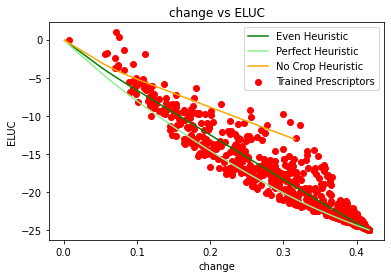

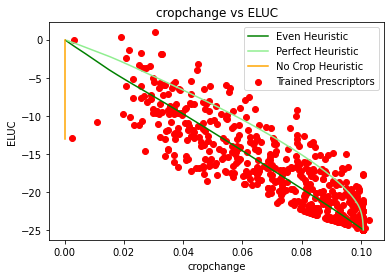

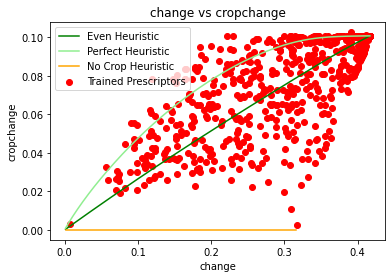

In [28]:
# all_results = {
#     "Even Heuristic": {"change": even_changes, "ELUC": even_elucs, "cropchange": even_cropchanges, "color": "green"},
#     "Perfect Heuristic": {"change": perfect_changes, "ELUC": perfect_elucs, "cropchange": perfect_cropchanges, "color": "lightgreen"},
#     "Trained Prescriptors": {"change": changes, "ELUC": elucs, "cropchange": cropchanges, "color": "red"}
# }
# plot_result_pareto(["change", "ELUC"], all_results)
# plot_result_pareto(["cropchange", "ELUC"], all_results)
# plot_result_pareto(["change", "cropchange"], all_results)

plot_heuristic_comparison([1, 0])
plot_heuristic_comparison([2, 0])
plot_heuristic_comparison([1, 2])

In [29]:
non_dom = []
for i in range(len(elucs)):
    dominated = False
    for j in range(len(elucs)):
        if elucs[i] > perfect_elucs[j] and changes[i] > perfect_changes[j]:
            dominated = True
        if elucs[i] < perfect_elucs[j] and changes[i] < perfect_changes[j]:
            dominated = False
            break
    if not dominated:
        non_dom.append(i)
non_dom = np.array(non_dom)

In [30]:
def get_idx_close(change, changes):
    diff = [abs(c - change) for c in changes]
    idx = diff.index(min(diff))
    return idx

{0.31676374287310133: 0.3168701821943199, 0.007411019672279278: 0.007510300555696078, 0.39568840092612395: 0.39548065261795623, 0.41624385411130627: 0.41625939151139457, 0.3912325317389461: 0.3910621896786487, 0.37234378796792494: 0.3724173758018253, 0.2991287756171711: 0.2991492496166311, 0.39977746212168963: 0.39961752608112766, 0.41674525441059995: 0.4167254052199876, 0.4168297350242214: 0.416844439380585, 0.4039359812726084: 0.4037515288773547, 0.412352133471912: 0.41224025916807683, 0.32111705585708883: 0.3209750287436257, 0.40910651850095575: 0.409134040092268, 0.3957310185649568: 0.3959556534010096, 0.3421076082555141: 0.34198619583980205, 0.3662385391772895: 0.3661474357549244, 0.339856849419037: 0.34007852274204375, 0.416844439380585: 0.416844439380585, 0.3871743595867128: 0.38698671872569645, 0.4117647838557074: 0.4116597461877842, 0.3789061141388799: 0.3790519264901851, 0.30465205889013725: 0.3049240978107177, 0.40556410225010747: 0.4056544347602723, 0.23646217619319645: 0.2

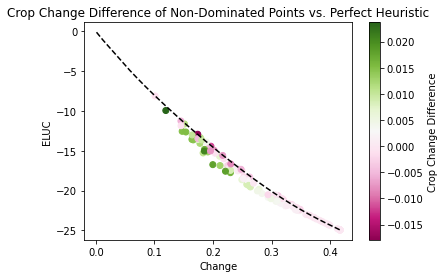

In [31]:
close_idxs = [get_idx_close(change, perfect_changes) for change in changes]

print(dict(zip(changes, perfect_changes[close_idxs])))

cropchange_diff = cropchanges - perfect_cropchanges[close_idxs]

idx = np.argsort(perfect_changes)
plt.plot(perfect_changes[idx], perfect_elucs[idx], color="black", linestyle="--")
plt.scatter(changes[non_dom], elucs[non_dom], c=cropchange_diff[non_dom], cmap="PiYG")
plt.colorbar(label="Crop Change Difference")
plt.title("Crop Change Difference of Non-Dominated Points vs. Perfect Heuristic")
plt.xlabel("Change")
plt.ylabel("ELUC")
plt.show()

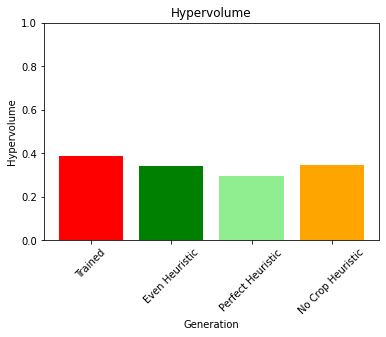

In [37]:
ref_point=np.array([0, max(perfect_changes), max(perfect_cropchanges)])
ideal=np.array([min(perfect_elucs), 0, 0])

nadir = ref_point
metric = Hypervolume(ref_point=ref_point,
                        norm_ref_point=True,
                        zero_to_one=True,
                        ideal=ideal,
                        nadir=nadir)

trained_hv = metric.do(trained_F)
even_hv = metric.do(even_F)
perfect_hv = metric.do(perfect_F)
crop_hv = metric.do(crop_F)

plt.bar(["Trained", "Even Heuristic", "Perfect Heuristic", "No Crop Heuristic"],
        [trained_hv, even_hv, perfect_hv, crop_hv],
        color=["red", "green", "lightgreen", "orange"])
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.title("Hypervolume")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.show()

In [26]:
def filter_dominating(changes, elucs):
    """
    Gets indices of points that are not dominated by any other point.
    """
    non_dominated_idxs = []
    for i in range(len(changes)):
        dominated = False
        for j in range(len(changes)):
            if i != j and changes[i] >= changes[j] and elucs[i] >= elucs[j]:
                dominated = True
                break
        if not dominated:
            non_dominated_idxs.append(i)
    
    return [changes[i] for i in non_dominated_idxs], [elucs[i] for i in non_dominated_idxs]


def two_dim_decreasing_neg_hypervolume(x, y, right=1):
    """
    Computes the hypervolume of a 2d pareto.
    We use the sklearn AUC function to find the area between our curve and y = 0,
    then we add the area of the rectangle to the right of the pareto.
    This assumes the y coordinate of the reference point is 0 (which it is in our ELUC case).
    We only consider points under y = 0, adding point 0,0 to the pareto if it is not there.
    :param x: List of x coordinates between [0, 1]
    :param y: List of y coordinates
    :param right: the rightmost edge to compute the rectangle to. Defaults to 1.
    """

    assert len(x) == len(y)
    assert all([0 <= x_i <= 1 for x_i in x])
    assert right >= max(x)

    # Filter out positive y values
    neg_idxs = [i for i in range(len(y)) if y[i] < 0]
    x = [x[i] for i in neg_idxs]
    y = [y[i] for i in neg_idxs]

    # Sort the pareto by x
    sorted_x = sorted(x)
    sorted_y = [y[x.index(sorted_x[i])] for i in range(len(x))]

    # Add point 0,0 if it is not there
    if sorted_x[0] != 0:
        sorted_x = [0] + sorted_x
        sorted_y = [0] + sorted_y

    # Add bottom right point if it is not there
    if sorted_x[-1] != right:
        sorted_x.append(right)
        sorted_y.append(sorted_y[-1])

    # Take the rectangle that is to the top right of each point.
    area = 0
    for i in range(len(sorted_x) - 2, -1, -1):
        area += (sorted_x[i] - sorted_x[i + 1]) * sorted_y[i]

    return area

In [27]:
# Filter out points that are dominated by others
changes_filtered, elucs_filtered = filter_dominating(changes_sorted, elucs_sorted)

print(f"Even hypervolume: {two_dim_decreasing_neg_hypervolume(even_changes, even_elucs)}")
print(f"Perfect hypervolume: {two_dim_decreasing_neg_hypervolume(perfect_changes, perfect_elucs)}")
print(f"Trained hypervolume: {two_dim_decreasing_neg_hypervolume(changes_filtered, elucs_filtered)}")

Even hypervolume: 19.878278830833306
Perfect hypervolume: 20.445184251826745
Trained hypervolume: 20.61202668767982


## Examine Results

In [38]:
def get_idx_close(change, changes):
    diff = [abs(c - change) for c in changes]
    idx = diff.index(min(diff))
    return idx

def plot_selected_points(selected_points, save_path=None):
    for point_name, point in selected_points.items():
        plt.scatter([point[0]], [point[1]], color=point[2], label=point_name)

    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    plt.xlim([0, 0.4])
    plt.ylim([-25, 0])
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

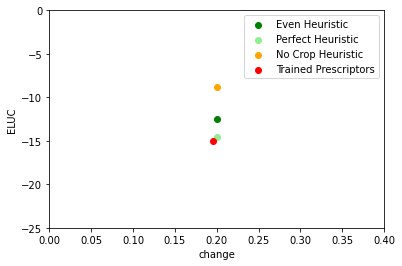

In [46]:
sort_idxs = np.argsort(changes)
changes_sorted = changes[sort_idxs]
elucs_sorted = elucs[sort_idxs]

pct = 0.2
even_idx = get_idx_close(pct, even_changes)
perfect_idx = get_idx_close(pct, perfect_changes)
crop_idx = get_idx_close(pct, crop_changes)
idx = get_idx_close(pct, changes_sorted) - 7

selected_points = {
    "Even Heuristic": (even_changes[even_idx], even_elucs[even_idx], "green"),
    "Perfect Heuristic": (perfect_changes[perfect_idx], perfect_elucs[perfect_idx], "lightgreen"),
    "No Crop Heuristic": (crop_changes[crop_idx], crop_elucs[crop_idx], "orange"),
    "Trained Prescriptors": (changes_sorted[idx], elucs_sorted[idx], "red"),
}

plot_selected_points(selected_points)

In [48]:
def trained_prescribe_and_predict(prescriptor_manager: PrescriptorManager, cand_id: str, context_df: pd.DataFrame):
    context_actions_df = prescriptor_manager.prescribe(cand_id, context_df)
    outcome_df = prescriptor_manager.predict_metrics(context_actions_df)
    context_actions_df["ELUC"] = outcome_df["ELUC"]
    context_actions_df["change"] = outcome_df["change"]
    context_actions_df["cropchange"] = outcome_df["cropchange"]
    return context_actions_df

In [54]:
unsorted_idx = np.where(changes == changes_sorted[idx])[0][0]
trained_id = all_pareto_df["id"].iloc[unsorted_idx]
trained_result = trained_prescribe_and_predict(torch_manager, trained_id, context_df)

even_result = trained_prescribe_and_predict(even_manager, str(pcts[even_idx]), context_df)
perfect_result = trained_prescribe_and_predict(perfect_manager, str(pcts[perfect_idx]), context_df)
no_crop_result = trained_prescribe_and_predict(crop_manager, str(pcts[crop_idx]), context_df)

In [55]:
def plot_expanded(result_dict: dict, save_path=None):
    # Evolved first so that it is on the bottom
    for sample_name, result in result_dict.items():
        plt.scatter(result[0], result[1], color=result[2], label=sample_name)
    
    # Rearrange legend (from stackoverflow)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [1, 2, 0]
    # plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    #plt.title("Expanded view of ~20% change prescriptors (subsampled)")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

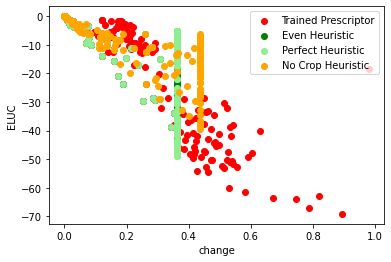

In [58]:
sample =  trained_result.sample(frac=0.01, random_state=42)
even_sample = even_result.loc[sample.index]
perfect_sample = perfect_result.loc[sample.index]
no_crop_sample = no_crop_result.loc[sample.index]

expanded_results = {
    "Trained Prescriptor": (sample["change"], sample["ELUC"], "red"),
    "Even Heuristic": (even_sample["change"], even_sample["ELUC"], "green"),
    "Perfect Heuristic": (perfect_sample["change"], perfect_sample["ELUC"], "lightgreen"),
    "No Crop Heuristic": (no_crop_sample["change"], no_crop_sample["ELUC"], "orange"),
}

plot_expanded(expanded_results)

In [59]:
def create_diff_df(trained_result, perfect_result):
    eluc_diff = trained_result["ELUC"] - perfect_result["ELUC"]
    change_diff = trained_result["change"] - perfect_result["change"]
    diff_df = pd.concat([eluc_diff, change_diff], axis=1)

    return diff_df

In [60]:
trained_diff = create_diff_df(sample, perfect_sample)

In [61]:
def plot_diffs(diff_df, save_path=None):
    
    dom = diff_df[(diff_df["change"] < 0) & (diff_df["ELUC"] < 0)]
    other_dom = diff_df[(diff_df["change"] > 0) & (diff_df["ELUC"] > 0)]

    plt.scatter(diff_df["change"], diff_df["ELUC"], label="No domination")
    plt.scatter(other_dom["change"], other_dom["ELUC"], color="lightgreen", label="Perfect Heuristic dominates")
    plt.scatter(dom["change"], dom["ELUC"], color="red", label="Evolved Prescriptor dominates")
    plt.axhline(0, color="black", linestyle="--")
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Change Difference")
    plt.ylabel("ELUC Difference")
    #plt.title("Change Diff vs. ELUC Diff Between Trained and Perfect (subsampled)")
    plt.legend()
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

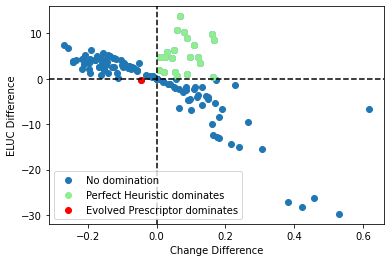

In [62]:
plot_diffs(trained_diff)

In [63]:
def display_dominating(diff_df):
    low_change_idx = diff_df["change"][(diff_df["change"] < 0)].index
    low_change_eluc_diff = diff_df["ELUC"][low_change_idx]
    low_change_neg_eluc_diff = low_change_eluc_diff[low_change_eluc_diff < 0]
    print(f"Number less change better ELUC: {len(low_change_neg_eluc_diff)}")
    if len(low_change_neg_eluc_diff) > 0:
        min_idx = low_change_neg_eluc_diff.sort_values().index[0]
        print(f"Max difference in ELUC with less change: {diff_df['ELUC'][min_idx]}")

    signif = low_change_neg_eluc_diff[abs(low_change_neg_eluc_diff) > 0.05]
    print(f"Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: {len(signif)}")
    print(f"Average difference in change for these points: {diff_df['change'].loc[signif.index].mean()}")
    print(f"Average difference in ELUC for these points: {signif.mean()}")
    print()

In [64]:
display_dominating(trained_diff)

Number less change better ELUC: 1
Max difference in ELUC with less change: -0.1731243133544922
Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: 1
Average difference in change for these points: -0.04667264223098755
Average difference in ELUC for these points: -0.1731243133544922



In [65]:
def plot_avg_presc(result_dict, save_path=None):
    xticks = np.arange(len(constants.DIFF_RECO_COLS))
    i = 0
    width = 1 / (len(result_dict) + 1)
    for result_name, result in result_dict.items():
        plt.bar(xticks + i * width, result[0][constants.DIFF_RECO_COLS].mean(), width=width, label=result_name, color=result[1])
        i += 1
    
    plt.xticks(xticks + (len(result_dict)-1)/2 * width, constants.DIFF_RECO_COLS, rotation=90)
    plt.legend()
    plt.grid()
    #plt.title("Average land use change for each prescriptor")
    fig = plt.gcf()
    fig.set_tight_layout(True)
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

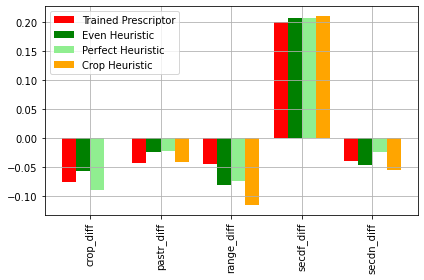

In [67]:
plot_avg_presc({
    "Trained Prescriptor": (sample, "red"),
    "Even Heuristic": (even_sample, "green"),
    "Perfect Heuristic": (perfect_sample, "lightgreen"),
    "Crop Heuristic": (no_crop_sample, "orange")
})

#### See what features cause more change

In [68]:
def plot_corrs(result_df, save_path=None):
    rs = []
    for col in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
        feat = result_df[col]
        if col == "lat" or col == "lon":
            feat = abs(feat)
        rs.append(feat.corr(result_df["change"]))
    print(rs)

    labels = constants.LAND_USE_COLS + constants.NONLAND_FEATURES
    labels[labels.index("lat")] = "abs(lat)"
    labels[labels.index("lon")] = "abs(lon)"
    plt.bar(labels, rs)
    plt.xticks(rotation=90)
    plt.xlabel("Context Feature")
    plt.ylabel("r value")
    plt.title("Linear Correlation Between Context and Amount of Prescribed Change")
    plt.grid(axis="y")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

[0.6415668450449573, 0.7036883503630178, -0.352364966682547, -0.2676010271280559, 0.08186315745323902, -0.13528943038060004, 0.30148426155178915, 0.14055071133850733, 0.48594358849532293, -0.42940779125985146, -0.3025057139019493, 0.010072139548836123]


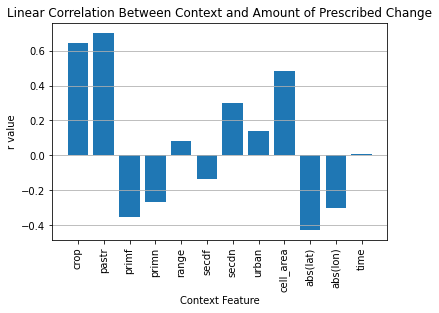

In [69]:
plot_corrs(trained_result)

In [70]:
def plot_context_change(trained_sample, feature, save):
    plt.scatter(trained_sample[feature], trained_sample["change"])
    plt.title(f"Context {feature} vs. Amount of Prescribed Change")
    plt.ylabel("Change")
    plt.xlabel(feature)
    if feature in constants.LAND_USE_COLS:
        plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="y=x")
        plt.plot([0, 1], [1, 0], color="red", linestyle="--", label="y=1-x")
        plt.legend()
    if save:
        plt.savefig(f"figures/{feature}change.png", format="png", dpi=300)
    plt.show()

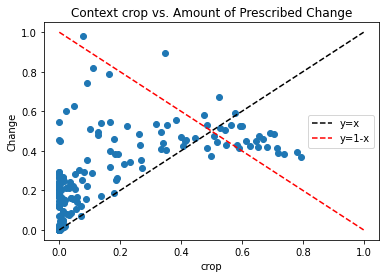

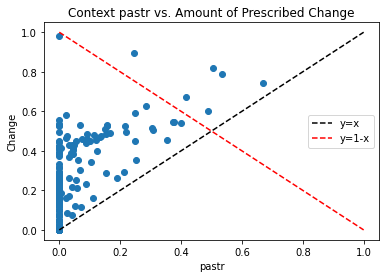

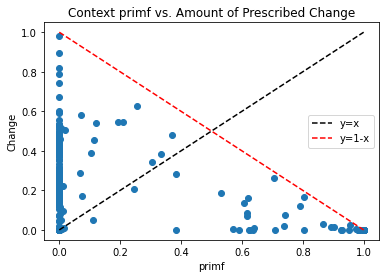

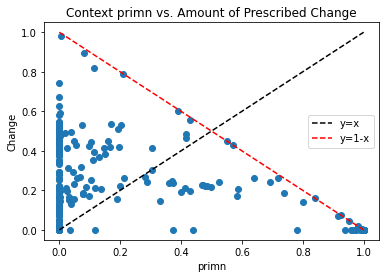

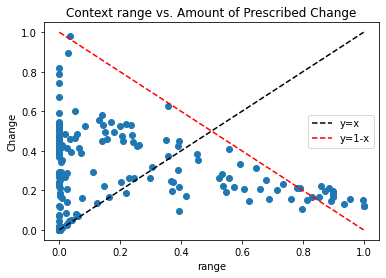

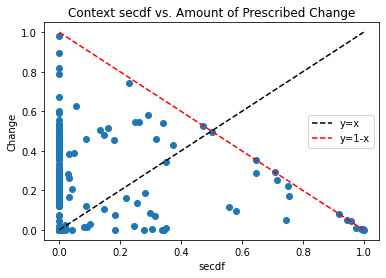

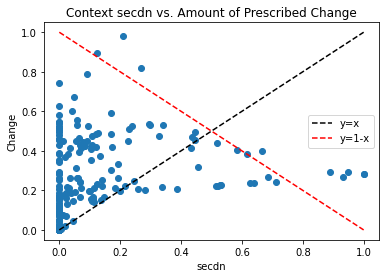

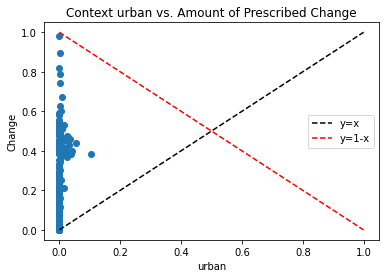

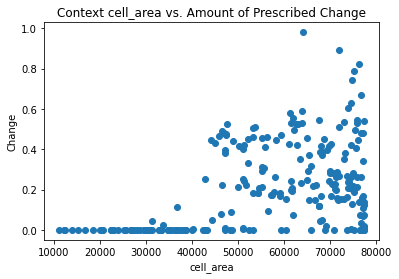

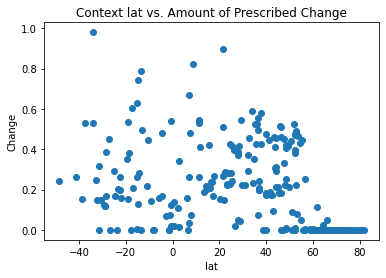

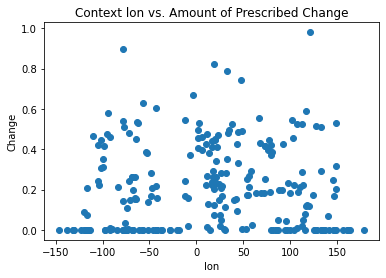

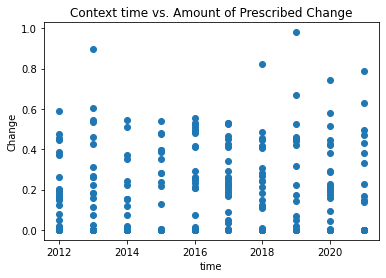

In [71]:
for feature in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    plot_context_change(sample, feature, False)

## Compare to Global Warming

In [50]:
pcts = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
total_emissions = []
total_changes = []
warming_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, predictors)
for pct in tqdm(pcts):
    result_df = warming_manager.prescribe(str(pct), dataset.test_df.loc[2021][constants.CAO_MAPPING["context"]])
    outcome_df = perfect_manager.predict_metrics(result_df)
    result_df["ELUC"] = outcome_df["ELUC"]
    result_df["change"] = outcome_df["change"]
    result_df["total_emissions"] = result_df["ELUC"] * result_df["cell_area"]
    result_df["total_change"] = result_df["change"] * result_df["cell_area"]
    total_emissions.append(result_df["total_emissions"].sum())
    total_changes.append(result_df["total_change"].sum() / result_df["cell_area"].sum())

100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


In [51]:
# Weight of CO2 vs. C
conversion = 3.664
# Remaining Carbon budget
rcb = 250
rcb2 = 1200
# Yearly net emissions
yearly = 20

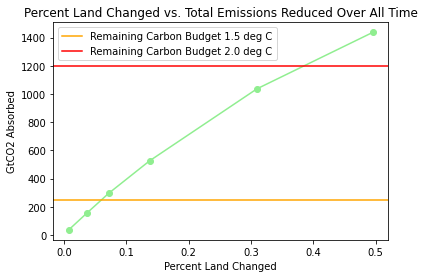

In [52]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [-1 * t * conversion / 1e9 for t in total_emissions], marker="o", color="lightgreen")
plt.axhline(y=rcb, color='orange', label="Remaining Carbon Budget 1.5 deg C")
plt.axhline(y=rcb2, color='red', label="Remaining Carbon Budget 2.0 deg C")
plt.legend()
plt.title("Percent Land Changed vs. Total Emissions Reduced Over All Time")
plt.ylabel("GtCO2 Absorbed")
plt.xlabel("Percent Land Changed")
plt.show()

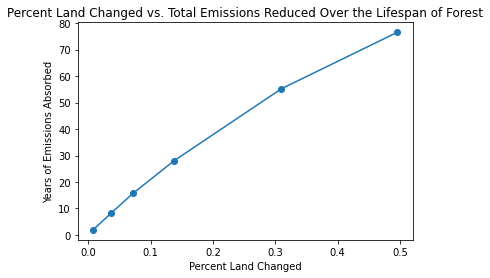

In [53]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [t / (-18.78e9 / conversion) for t in total_emissions], marker="o")
plt.title("Percent Land Changed vs. Total Emissions Reduced Over the Lifespan of Forest")
plt.xlabel("Percent Land Changed")
plt.ylabel("Years of Emissions Absorbed")
plt.show()